<a href="https://colab.research.google.com/github/jatoogunhyo/dart_disclosure/blob/main/kospi_buyback_mkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 질문: 근래 코스피 상장사들의 자기주식 "장내" 취득/처분 현황은 어떻게 될까?

✅ **배경-자사주 취득/처분방법**
* 자사주는 장내(거래소) 및 장외에서 취득/처분이 가능함
* 장내에서 "직접" 취득/처분하는 경우 거래소 사전신고 필수
  - (배경-거래소 신고) 참조
* 장외의 예시는 공개매수, 증여, 계좌대체 등이 있음
  - 한편, 시간외대량매매는 장내로 구분됨  <br/>

✅ **배경-금감원 서식**
*   자기주식 취득은 법에 따라 금감원 공시(주요사항보고서)로 제출
  - 이사회에서 '결의'한 시점에 제출된 공시이므로, 취득'예정'수량/금액임
  - 실제 취득은 결의한 수량/금액보다 적을 수 있음
  <br/>
* 자기주식 취득이 완료되면 자기주식 취득결과 보고서를 금감원 공시로 제출
  - 그러나 주요사항보고서는 OpenDart에서 서비스하는 반면, 결과보고서는 OpenDart에서 서비스하지 않음

✅ **배경-거래소 신고**
*   자기주식 취득을 위해 장내에서 주문 제출시 상장법인은 거래소에 사전에 신고하고, 주문호가에 자사주 매매에 관한 내용이 태깅됨
  - 이는 자본시장법 위반을 방지하기 위한 모니터링임
  - 관할부서는 공시부가 아닌 주식시장부/코스닥시장부
  - 대상 시스템은 상공시스템이 아닌 Exture
* 그러나 거래소는 시장을 운영하는 곳으로, 장외 취득/처분 수량은 거래소 시스템에 신고되지 않음
  - 장외 수량은 금감원 서식(결정공시 및 결과보고서)으로만 확인 가능



# 파이썬 세팅

* 필요한 패키지 Import

In [1]:
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np

* 시각화를 위한 세팅(코랩)
코랩 환경에서 시각화에 한글이 깨지지 않도록 조치

In [2]:
# 필요한 라이브러리 설치
!pip install adjustText

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

# 거래소 기준의 자사주 취득/처분 통계 불러오기
(장내 수량만 카운트 됨. 장외 자사주 취득은 카운트 안됨)

* 정보데이터시스템(data.krx.co.kr)에서 자동으로 자료 다운받기

In [3]:
st_y = input('시작연도를 입력하세요(2012년부터 데이터 제공): ')
end_y = input('종료연도를 입력하세요: ')

시작연도를 입력하세요(2012년부터 데이터 제공): 2015
종료연도를 입력하세요: 2024


In [4]:
#거래소 홈페이지에서 불러오기
#화면번호 20004(자사주취득/처분종목현황)

gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': f'{st_y}0101',
    'endDd': f'{end_y}1224',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20601'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

In [5]:
# 확인해보기
print("행의 개수: " + str(len(df_buyback)))
df_buyback.tail()

행의 개수: 4724


,공시일,종목코드,종목명,시장구분,직접/신탁,취득/처분,취득(처분)예정기간_시작일,취득(처분)예정기간_종료일,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_체결수량비율,체결내역(누계)_금액
4719,2015/01/06,000150,두산,KOSPI,신탁,취득,2015/01/06,2016/01/05,0,10000000000,87558.0,0.00,9.966629e+09
4720,2015/01/06,000150,두산,KOSPI,신탁,취득,2015/01/06,2016/01/05,0,10000000000,94757.0,0.00,9.976392e+09
4721,2015/01/06,024880,케이피에프,KOSDAQ,직접,취득,2015/01/07,2015/01/30,49204,173936140,49204.0,100.00,1.882532e+08
4722,2015/01/05,090740,연이비앤티,KOSDAQ,직접,취득,2015/01/06,2015/04/05,1000000,2300000000,1000000.0,100.00,2.682323e+09
4723,2015/01/02,044450,KSS해운,KOSPI,직접,취득,2015/01/05,2015/04/04,160000,2008000000,99121.0,61.95,1.236307e+09


* 연도별 유형별 취득수량/취득금액 구하기

In [32]:
# df_listed DataFrame 사용하여 연도별 유형별 취득수량/처분수량
# '공시일' 칼럼을 날짜형태로 변환
df_buyback['공시일'] = pd.to_datetime(df_buyback['공시일'])

# '공시일' 칼럼에서 연도를 뽑아내기
df_buyback['year'] = df_buyback['공시일'].dt.year

# 기준을 정하여 그룹화
grouped = df_buyback.groupby(['시장구분','year', '직접/신탁', '취득/처분']).agg({
    '신고내역_수량' : 'sum',
    '신고내역_금액' : 'sum',
    '체결내역(누계)_수량' : 'sum',
    '체결내역(누계)_금액' : 'sum'
}).reset_index()

# 원 -> 억 원 변환
grouped['신고내역_금액'] = grouped['신고내역_금액'] / 1e8
grouped['체결내역(누계)_금액'] = grouped['체결내역(누계)_금액'] / 1e8

# 시장구분: 유가
# 직접
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con2 & con3]

In [33]:
#확인해보기
grouped_con

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_금액
64,KOSPI,2015,직접,취득,137975612,97324.200013,137410358.0,97282.785180
67,KOSPI,2016,직접,취득,43658944,87816.815308,39048576.0,91598.485443
71,KOSPI,2017,직접,취득,36564065,94788.691713,35798399.0,97787.197844
75,KOSPI,2018,직접,취득,71057392,46784.117565,69153688.0,46567.165835
79,KOSPI,2019,직접,취득,33896491,22946.828688,33255244.0,24935.938294
83,KOSPI,2020,직접,취득,196677711,27690.730841,187033380.0,27639.224016
86,KOSPI,2021,직접,취득,75018607,21386.814897,74750544.0,21067.731705
90,KOSPI,2022,직접,취득,79342560,24515.781669,70531297.0,25016.778395
94,KOSPI,2023,직접,취득,77204876,31722.222295,74650467.0,31970.256971
98,KOSPI,2024,직접,취득,160388173,75488.742240,130233691.0,59163.034585


# 자사주 취득 신고대비 실제 취득비중 확인하기(장내취득限)

### 거래소 데이터로 신고대비 실제취득 확인(시각화)
취득방법에는 '직접/신탁/스톡옵션'이 있는데,</br>
거래소에 사전신고하는 것은 '직접'에만 해당</br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

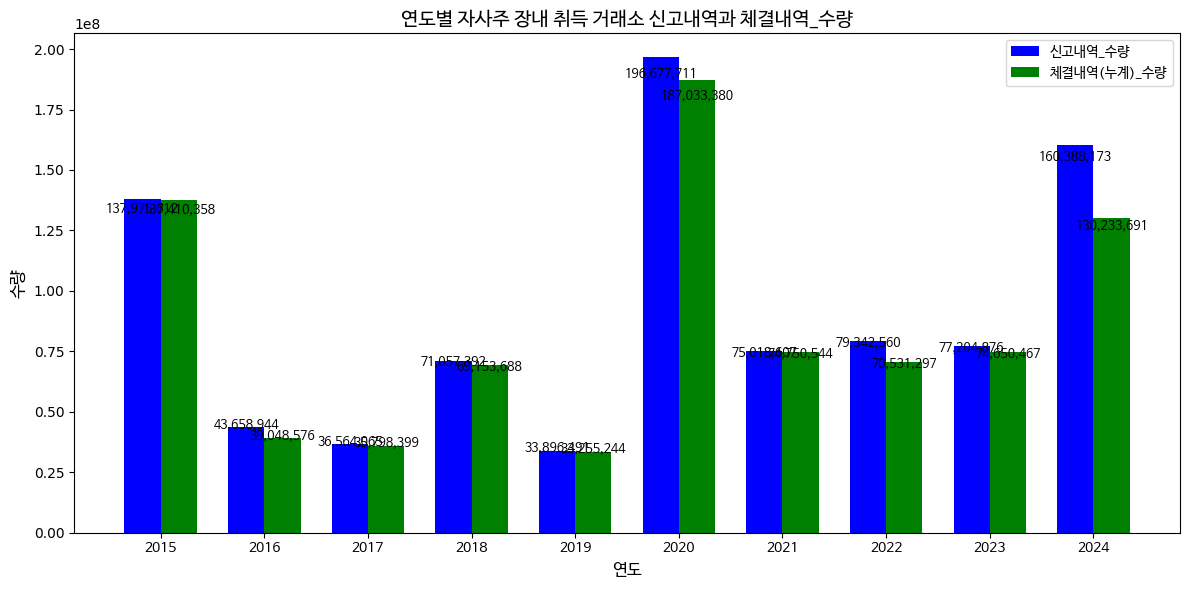

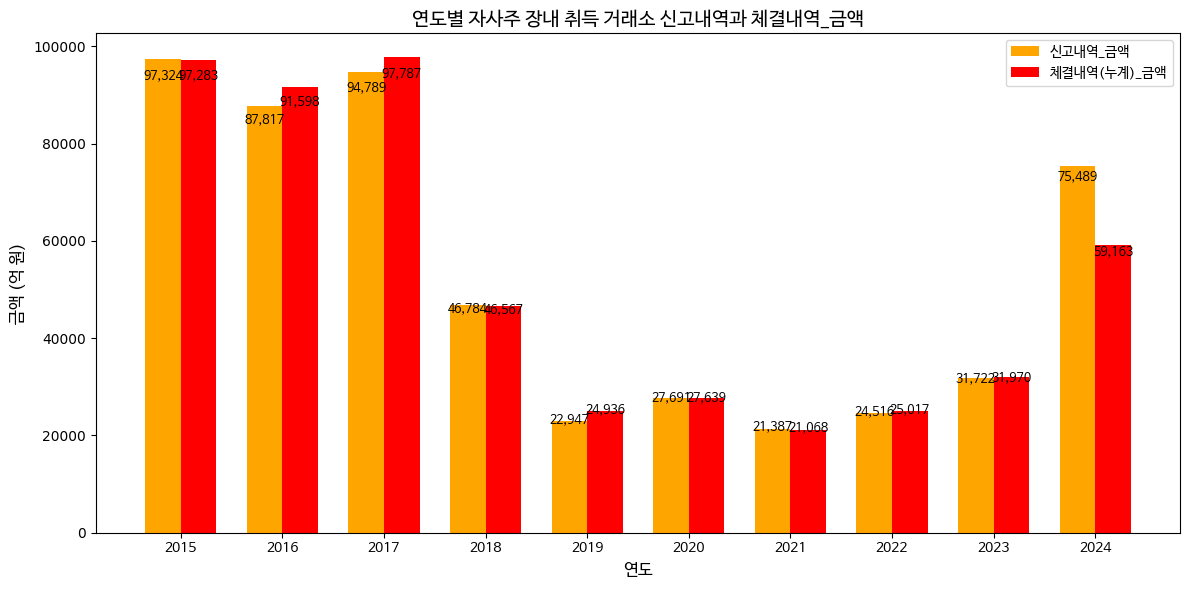

In [35]:
# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']

# 1. 취득예정주식과 체결내역(누계)_수량 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))  # X축 위치
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
plt.title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()

# 2. 취득예정금액과 체결내역(누계)_금액 비교
fig, ax2 = plt.subplots(figsize=(12, 6))

bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액'],
                width=bar_width, color='orange', label='신고내역_금액')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액'],
                width=bar_width, color='red', label='체결내역(누계)_금액')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
plt.title('연도별 자사주 장내 취득 거래소 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()


# 직접취득 vs 신탁취득 비중확인하기

## 체결수량(주) 기준

앞서 취득방법(직접/신탁/스톡옵션)에서 '직접'으로 필터를 했으므로 </br>
다시 전체로 필터 해제하는 것을 수행

In [36]:
# 시장구분: 유가
# 직접/신탁/스톡옵션
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con3]

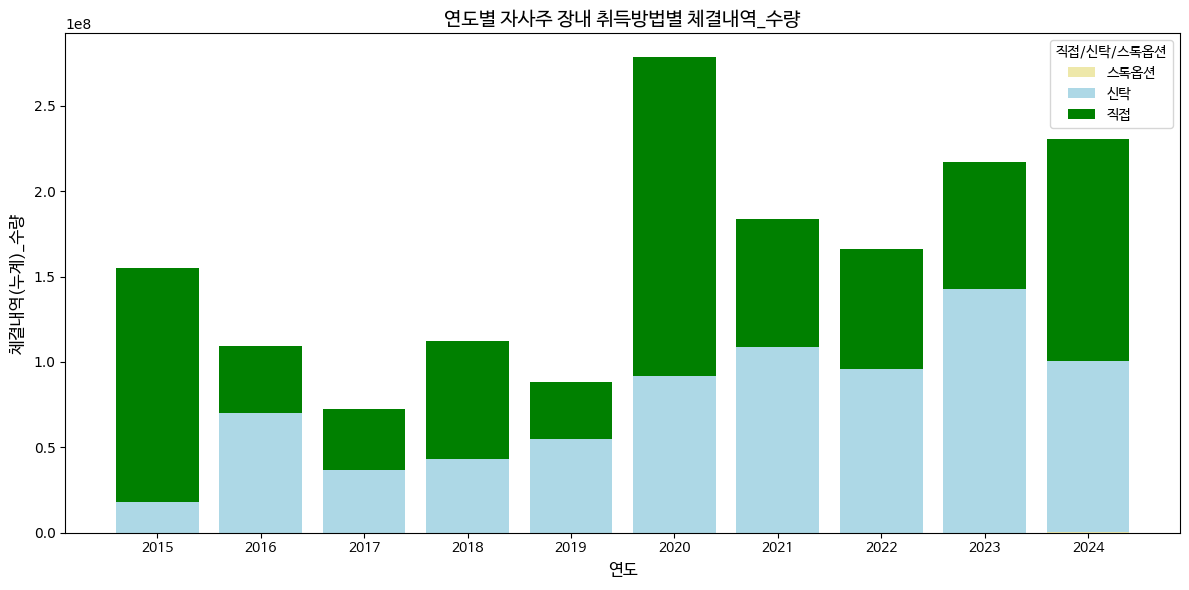

In [37]:
# 1. 취득예정주식과 체결내역(누계)_수량 비교 (legend 제목 폰트 수정)
fig, ax1 = plt.subplots(figsize=(12, 6))

pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors = ['palegoldenrod', 'lightblue', 'green']
#사용가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose
bottom_stack = np.zeros(len(pivot_quantity))

for idx, col in enumerate(pivot_quantity.columns):
    ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors[idx]
    )
    bottom_stack += pivot_quantity[col]

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='직접/신탁/스톡옵션',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

plt.title('연도별 자사주 장내 취득방법별 체결내역_수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

## 체결금액(억원) 기준

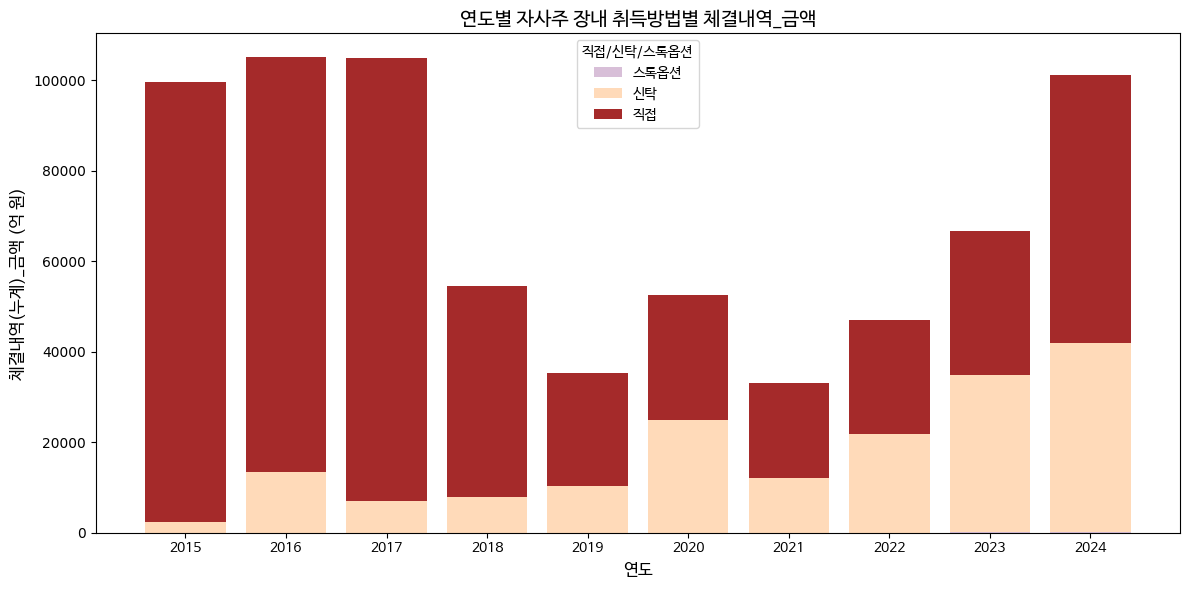

In [38]:
# 2. 취득예정금액과 체결내역(누계)_금액 비교 (legend 제목 폰트 수정)
fig, ax2 = plt.subplots(figsize=(12, 6))

# pivot_table로 데이터 재구성
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액',
    aggfunc='sum'
).fillna(0)

colors = ['thistle', 'peachpuff', 'brown']  # 신탁, 직접, 스톡옵션 순서
#사용가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose
bottom_stack = np.zeros(len(pivot_amount))  # 초기 바텀 값

# 스택드 바 차트 생성
for idx, col in enumerate(pivot_amount.columns):
    ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors[idx]
    )
    bottom_stack += pivot_amount[col]

# X축, Y축 및 제목 폰트 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액 (억 원)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax2.legend(
    title='직접/신탁/스톡옵션',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

plt.title('연도별 자사주 장내 취득방법별 체결내역_금액', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

# 자사주 처분 신고대비 실제 처분비중 확인하기(장내처분限)

처분방법에는 '직접/신탁'이 있는데,</br>
거래소에 사전신고하는 것은 '직접'에만 해당</br>
따라서 분석대상 데이터프레임을 '직접'으로 먼저 필터링하였음

In [39]:
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con2 & con3]

### 거래소 데이터로 신고대비 실제처분 확인(시각화)

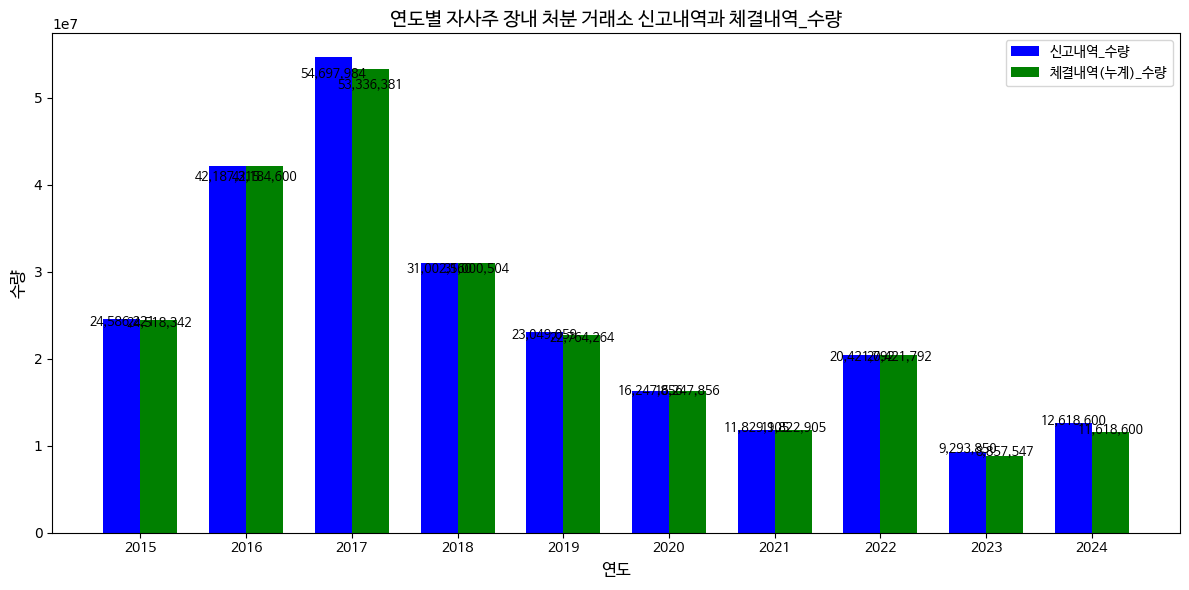

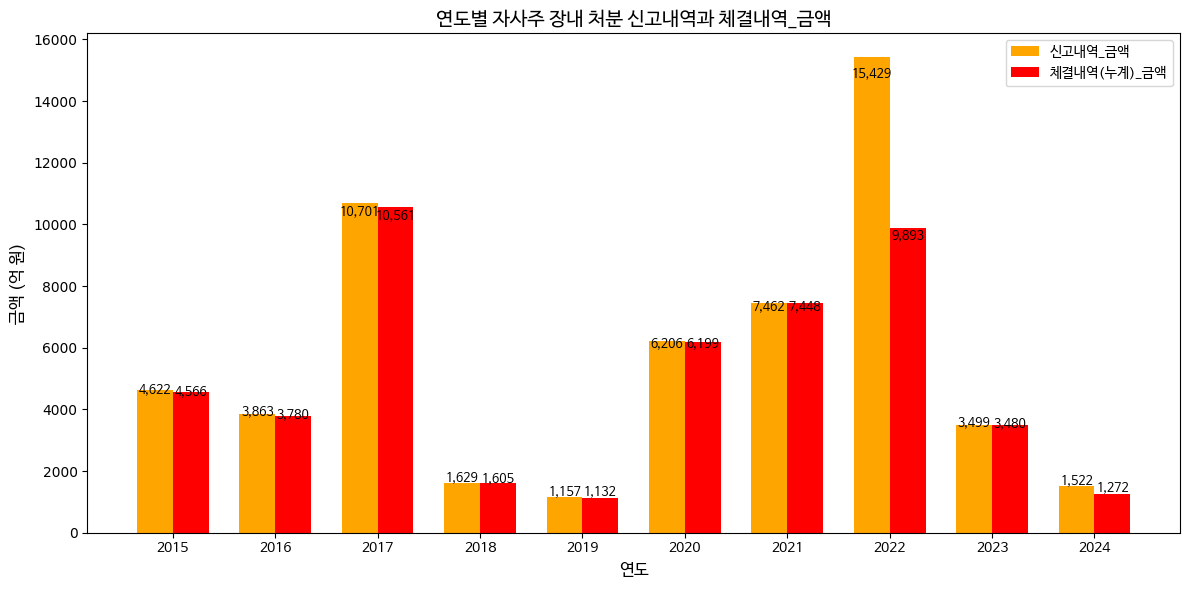

In [40]:
# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']

# 1. 취득예정주식과 체결내역(누계)_수량 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))  # X축 위치
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
plt.title('연도별 자사주 장내 처분 거래소 신고내역과 체결내역_수량', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()

# 2. 취득예정금액과 체결내역(누계)_금액 비교
fig, ax2 = plt.subplots(figsize=(12, 6))

bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액'],
                width=bar_width, color='orange', label='신고내역_금액')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액'],
                width=bar_width, color='red', label='체결내역(누계)_금액')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
plt.title('연도별 자사주 장내 처분 신고내역과 체결내역_금액', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()


# 직접처분 vs 신탁처분 비중확인하기

* 분석대상 데이터프레임 구하기

In [43]:
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
#con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con = grouped[con1 & con3]

## 체결수량(주) 기준

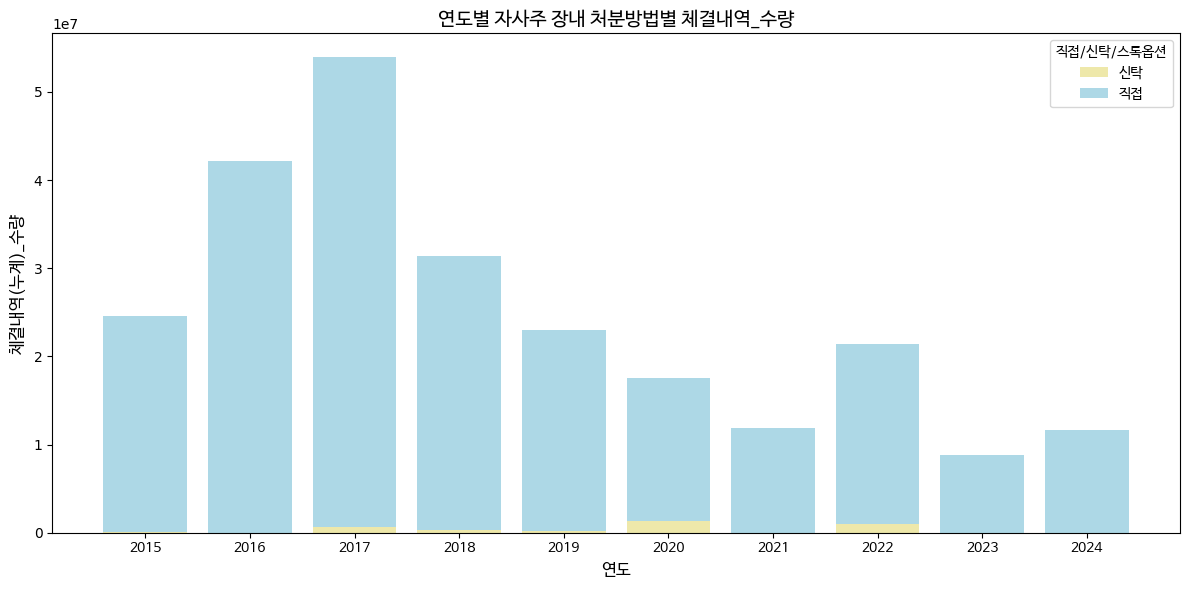

In [44]:
# 1. 취득예정주식과 체결내역(누계)_수량 비교 (legend 제목 폰트 수정)
fig, ax1 = plt.subplots(figsize=(12, 6))

pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_수량',
    aggfunc='sum'
).fillna(0)

colors = ['palegoldenrod', 'lightblue', 'green']
#사용가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose
bottom_stack = np.zeros(len(pivot_quantity))

for idx, col in enumerate(pivot_quantity.columns):
    ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors[idx]
    )
    bottom_stack += pivot_quantity[col]

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('체결내역(누계)_수량', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='직접/신탁/스톡옵션',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

plt.title('연도별 자사주 장내 처분방법별 체결내역_수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

## 체결금액(억원) 기준

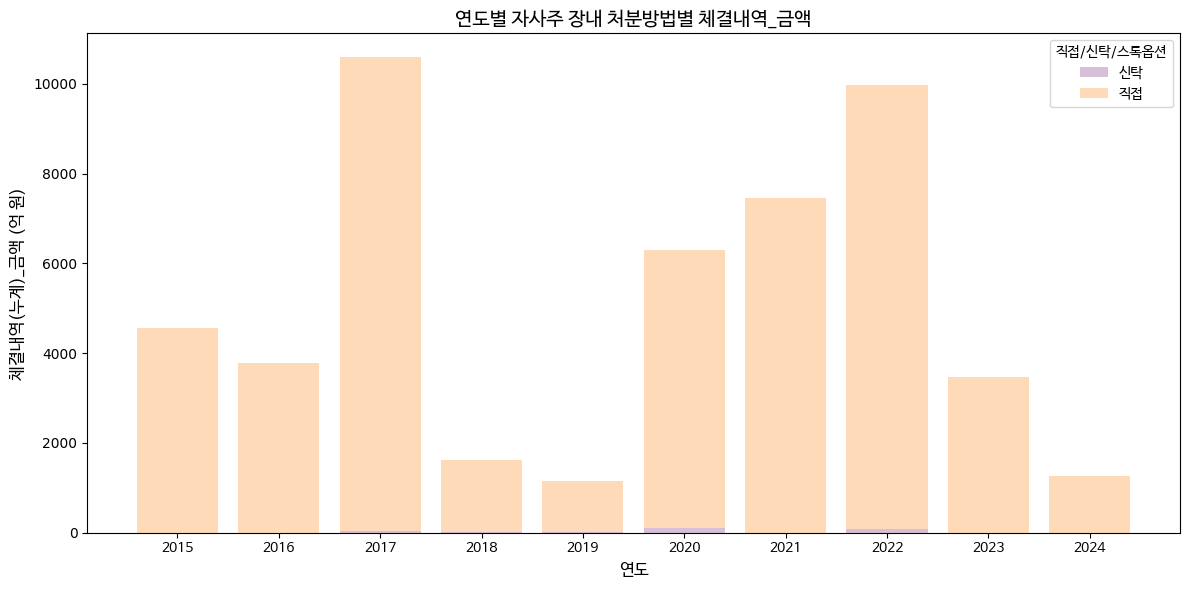

In [45]:
# 2. 취득예정금액과 체결내역(누계)_금액 비교 (legend 제목 폰트 수정)
fig, ax2 = plt.subplots(figsize=(12, 6))

# pivot_table로 데이터 재구성
pivot_amount = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결내역(누계)_금액',
    aggfunc='sum'
).fillna(0)

colors = ['thistle', 'peachpuff', 'brown']  # 신탁, 직접, 스톡옵션 순서
#사용가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose
bottom_stack = np.zeros(len(pivot_amount))  # 초기 바텀 값

# 스택드 바 차트 생성
for idx, col in enumerate(pivot_amount.columns):
    ax2.bar(
        pivot_amount.index,
        pivot_amount[col],
        bottom=bottom_stack,
        label=col,
        color=colors[idx]
    )
    bottom_stack += pivot_amount[col]

# X축, Y축 및 제목 폰트 설정
ax2.set_xticks(pivot_amount.index)
ax2.set_xticklabels(pivot_amount.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('체결내역(누계)_금액 (억 원)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax2.legend(
    title='직접/신탁/스톡옵션',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

plt.title('연도별 자사주 장내 처분방법별 체결내역_금액', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
# 내역 확인
grouped_con

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_금액
61,KOSPI,2015,신탁,처분,0,10.000000,26158.0,4.406297
63,KOSPI,2015,직접,처분,24586221,4621.913162,24518342.0,4566.196264
66,KOSPI,2016,직접,처분,42187315,3862.671926,42184600.0,3779.561027
68,KOSPI,2017,신탁,처분,0,220.000000,612645.0,33.290799
70,KOSPI,2017,직접,처분,54697984,10700.870624,53336381.0,10561.418530
72,KOSPI,2018,신탁,처분,0,45.000000,345019.0,12.773066
74,KOSPI,2018,직접,처분,31002560,1628.550390,31000504.0,1604.823691
76,KOSPI,2019,신탁,처분,0,20.000000,200000.0,13.598219
78,KOSPI,2019,직접,처분,23049059,1156.786067,22764264.0,1132.103500
80,KOSPI,2020,신탁,처분,0,70.000000,1276626.0,107.306683
